# ASTR-5470 Final project 

This final project adapt Athena++ to be able to solve the Hall term for the MHD problem.
All of the test is done on Rivanna.
I remain some of the words in ASTR-5470 #Homework 7 to descript how to run Athena++ on Rivanna.   

## Setup environment on Rivanna 

Most of the words grabbed from ASTR-5470 #Homework7

Start by logging into Rivanna.  
The command line in a Linux machines would be
```
ssh -X kdj8qp@rivanna.hpc.virginia.edu
```
Please replace username (kdj8qp here) with your username. 

Go to a direction you want to put athena code.

git clone the public version of athena here
```
git clone https://github.com/PrincetonUniversity/athena.git
```
This should create a directory called athena.  

Then, we can load the necessary modules for compiling with mpi:
```
module purge
module load gcc
module load openmpi
module load python
```

You can run a script or directly run the following command line to compile:
```
cd athena
python configure.py --prob=linear_wave -mpi
make all
```

The `configure.py` creates a makefile that is then executed by calling `make`.

Create a bash script similar the `slurm.athena` in the class to submit the job on your scratch direction on Rivanna. The direction should be `/scratch/kdj8qp`, and please replace username (kdj8qp here) with your username.


## Test 1: Whistler waves 


There is an analytical solution for the Whistler waves dispersion relation that is:
$$
C_w = \frac{\omega}{k} = \pm  \frac{\eta_{\rm H} k }{2}  + \sqrt{\left( \frac{\eta_{\rm H}k}{2} \right)^2 +  C_{\rm A}^2} ,
$$
where $C_{\rm A}$ is the Alfven speed. From this dispersion relation, we get the Whistler wave phase velocity higher than Alfven speed if wavelength $\lambda = 2\pi/k_z <  c/\omega_{pi}$. It shows that the Hall term is essential for scale size less than the ion inertial length. 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rc('axes', linewidth=2)

def whistler_analytic(eta_h, k, CA):
    "retrun the Hall whistler waves analytical solutions"
    c_w = np.zeros((2,len(k)))
    c_w[0,:] = eta_h*k/2.0 + np.sqrt((eta_h*k/2.0)**2+CA**2)
    c_w[1,:] = -eta_h*k/2.0 + np.sqrt((eta_h*k/2.0)**2+CA**2)
    return c_w*k

I follow the  Marchand et al. 2018 to set the following initial conditions to finish the tests

$\rho = 1 {\rm g \ cm^{-3}}$

$v_x = v_y = v_z = 0$

$P = 1.5 \times 10^{-5} {\rm dyne cm^{−2}}$

$B_x = 0.1 {\rm G}$

$B_x = 0.001 {\rm cos}(2 \pi kx) {\rm G}$

$B_z = 0$

$\gamma = \frac{5}{3}$

$\eta_{\rm H} = 0.005$

The problem generator I called "linear_wave_Hall_whistler_dv.cpp", and the input file is the ""

I use the following configuration to:
python configure.py \
--prob=linear_wave_Hall_whistler_dv \
--flux=default \
--nscalars=0 \
-mpi \
-b \
-hdf5 \
-h5double \
--hdf5_path=$HDF5_ROOT

Because the processes to check the dispersion relation need to have a large amount data ($>$ 100GB), I just show how I do in the following steps and the figure.

First, I set a cubic box as same as  Marchand et al. 2018 but n1 x n2 x n3 = 128 x 32 x 32 to decrease the storage.

I plot the $v_y$ and the $B_y$ to check whether these quantities disperse or not.

Second, I use the Fast Fourier Transform (FFT) to turn $B_y$ to frequency domain ($f$).

Then, convert the values to the $\omega = 2 \pi f$

(-0.5, 1799.5, 1199.5, -0.5)

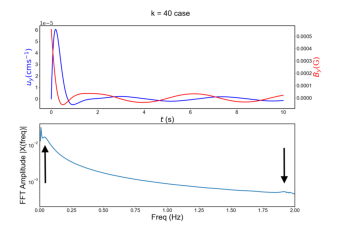

In [3]:
# Read the picture
import matplotlib.image as mpimg
image_path = "by_t_k40.png"
image = mpimg.imread(image_path)
plt.imshow(image)
plt.axis('off')

I find there are two peaks in the figure, and then choose them as the whistler waves frequency to present the frequency in the simulation.

I re-do the steps for different wave number $ k$

In [5]:
# read simulation output
# column 1 is k      (wavenumber)
# column 2 is omega1 (frequency1)
# column 3 is omega2 (frequency2)
f = np.loadtxt("whistler_wave_test.txt")
ks       = f[:, 0]
omegas_1 = f[:, 1]
omegas_2 = f[:, 2]


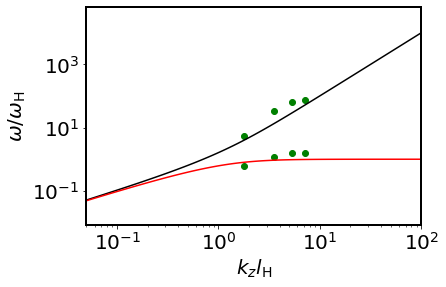

In [6]:

# Analytical test
# This test follows the Marchand et al. 2018 to test the Hall whistler wave
# This test are done in a cube box of length 1 cm
"""
Rho = 1.0          # 1 g/cm^3
P   = 1.5*10**-5   # 1.5 x 10^-5 dyne/cm^2
gamma = 5.0/3.0    # adiabatic
vx = vy = vz = 0   # 0 cm/s
bx = 0.1           # 0.1 G
by = 10**-3 * np.cos(2*np.pi*k*x) 
bz = 0             # 0   G
"""
Rho = 1.0
BB  = np.sqrt(0.1**2+0.001**2)
CA = BB/np.sqrt(4.0*np.pi*Rho)

eta_H = 5.0*10**-3
lH = eta_H/CA
omegaH = CA**2/eta_H

# analytical solution
k = np.logspace(-1.0, 3.0, num=100)
omega = whistler_analytic(eta_H, k, CA)
k *=lH
omega /=omegaH
plt.plot(k, omega[0], '-', color = 'k')
plt.plot(k, omega[1], '-', color = 'r')

# simulation output times the chartistic length and momentum frequency
ks *= lH
omegas_1 /= omegaH
omegas_2 /= omegaH
plt.scatter(ks,omegas_1, color='g')
plt.scatter(ks,omegas_2, color='g')

plt.ylabel(r'$\omega/\omega_{\rm H}$',fontsize=20)
plt.xlabel(r'$k_zl_{\rm H}$',fontsize=20)
plt.xlim(0.05,100)
plt.xscale('log')
plt.yscale('log')

It seems the results are not as good as I expected. 
I also try the small $k$ and the large $k$ but they have larger errors in the end.

## Test 2. : Hall drift waves
Same as test 1, there is an analytical solution for the Hall drift waves that is:
$$
\omega = \frac{k_yB}{4\pi ne}\frac{1}{n}\frac{\partial n}{\partial x} = k_y V_{\rm A} \left(\frac{c}{L_n \omega_{pi}} \right), 
$$
where $L_n = (\partial {\rm ln} n / \partial x)^-1$ is the density gradient scale length. This form shows that the Hall MHD drift wave propagates in the ${\rm \bf B} \times \partial n$ direction.

Unfortunately, I don't find any reasonable test for this wave test. I will do it in the future when I need.

## Test 3. Brio and Wu Shock

Brio and Wu's shock is often a test for the MHD code. 
I use the shock_tube.cpp in the original Athena++ code, and only add a line to include the Hall effect term to check whether it works or not.
And the following two pictures are the comparison of one has no the Hall effect and the one has $\eta_{\rm H} = 0.1$.

(-0.5, 1799.5, 1199.5, -0.5)

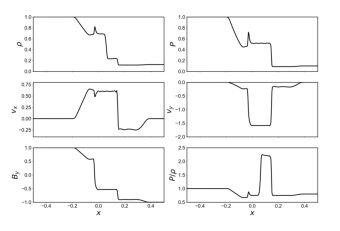

In [4]:
# Ideal MHD Brio & Wu shock
image_path = "no_Hall.png"
image = mpimg.imread(image_path)
plt.imshow(image)
plt.axis('off')

(-0.5, 1799.5, 1199.5, -0.5)

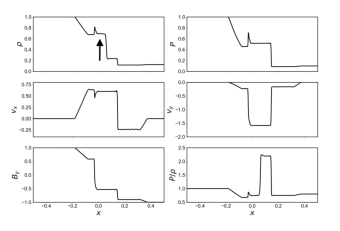

In [5]:
# add the Hall effect Brio & Wu shock
image_path = "have_Hall.png"
image = mpimg.imread(image_path)
plt.imshow(image)
plt.axis('off')

My results are shown there are no obvious difference between the ideal MHD case and the case with the Hall effect, which does not make sense. I think I need to correct this project more in the future.

Moreover, I only explicitly  add the EMF right now. I should modify the Riemann solver to add the Hall velocity term in the future. 